Import Libraries

In [32]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Resizing, Input, Normalization
from keras.models import Sequential
from IPython import display
import matplotlib.pyplot as plt
%matplotlib widget

We donwload and extract required dataset using `pathlib` module

In [3]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)

tf.keras.utils.get_file(
    'voicedataset.zip',
    origin='http://aiolearn.com/dl/datasets/voicedata.zip',
    extract=True,
    cache_dir='.',
    cache_subdir='data'
)

print('DONE!')

DONE!


In [4]:
tf.io.gfile.listdir(str(data_dir))

['right',
 'voicedataset.zip',
 'go',
 'no',
 'left',
 'stop',
 'README.md',
 'up',
 'down',
 'yes']

Defining commands

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[(commands != 'README.md') & (commands != 'voicedataset.zip')]

print('Available Commands: ', commands )

Available Commands:  ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


Creating dataset

In [6]:
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(directory=data_dir,
                                                              batch_size=64,
                                                              validation_split=0.2,
                                                              seed=0,
                                                              output_sequence_length=16000,
                                                              subset='both')

label_names = np.array(X_train.class_names)
print()
print('label : ', label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label :  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Here, we mix and merge the sound and its label with the `squeeze` command.

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test = X_test.map(squeeze, tf.data.AUTOTUNE)

In [8]:
X_train.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
# val = X_test
X_test = X_test.shard(num_shards=2,
                   index=0)
val = X_test.shard(num_shards=2,
                   index=1)

Here, with the ‍‍‍‍`take(1)` command, the X and Y values ​​of the first patch created are displayed.

In [10]:
for x, y in X_train.take(1):
    print(x)
    print(label_names[y])

tf.Tensor(
[[ 1.4648438e-03  4.5776367e-03  2.9602051e-03 ...  3.2653809e-03
   2.5634766e-03  3.6926270e-03]
 [ 6.9885254e-03  5.8898926e-03  6.7749023e-03 ...  9.4604492e-03
   8.2092285e-03  8.0566406e-03]
 [ 0.0000000e+00  8.5449219e-04 -3.9672852e-04 ...  3.7231445e-03
  -1.2817383e-03 -3.2043457e-03]
 ...
 [-1.3122559e-03 -1.6174316e-03 -2.5329590e-03 ... -2.9602051e-03
  -2.7770996e-03 -2.4719238e-03]
 [ 6.1035156e-05  3.0517578e-05 -3.0517578e-05 ... -1.5258789e-04
   3.0517578e-05  2.1362305e-04]
 [-3.0517578e-04 -2.2277832e-03 -2.8686523e-03 ... -3.0517578e-05
   2.7465820e-04  1.0375977e-03]], shape=(64, 16000), dtype=float32)
['down' 'go' 'right' 'no' 'down' 'left' 'yes' 'go' 'stop' 'go' 'left' 'up'
 'down' 'left' 'left' 'down' 'down' 'down' 'go' 'no' 'yes' 'right' 'up'
 'down' 'down' 'no' 'up' 'up' 'go' 'yes' 'yes' 'no' 'stop' 'stop' 'up'
 'go' 'right' 'stop' 'left' 'down' 'no' 'down' 'down' 'up' 'no' 'down'
 'down' 'go' 'stop' 'yes' 'no' 'stop' 'up' 'stop' 'right' 'go' 'y

In [11]:
for example_audio, example_labels in X_train.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [12]:
label_names[[0, 1, 2]]

array(['down', 'go', 'left'], dtype='<U5')

In [13]:
example_audio[0][5100]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0009460449>

Visualizing the commands signal

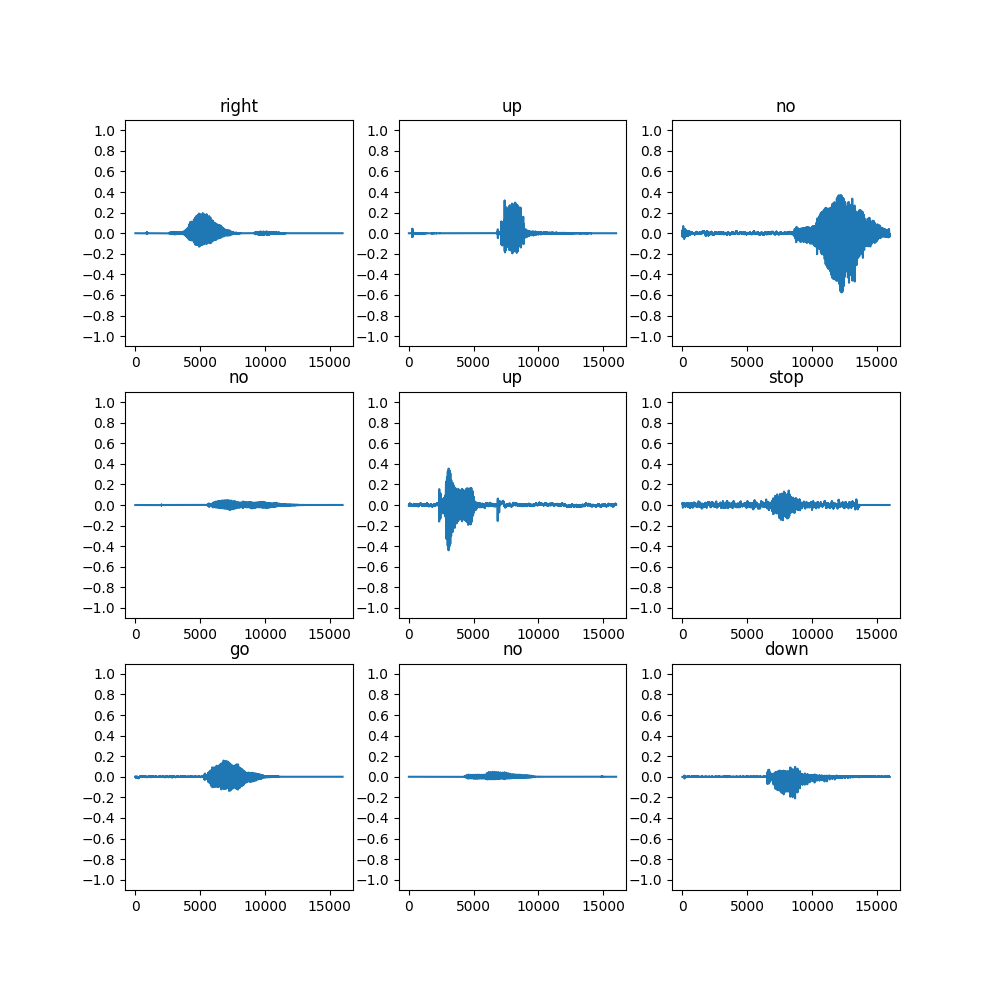

In [14]:
plt.figure(figsize=(10, 10))
rows, cols = (3, 3)
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

Now, we convert the waveform to a spectrogram via a `STFT`.

In [15]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform,
                                 frame_length=255,
                                 frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [16]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label: ', label)
    print('waveform shape: ', waveform.shape)
    print('Spectrogram shape: ', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label:  right
waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Label:  up
waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Label:  no
waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Defining a function for plotting spectrogram named `plot_spectrogram`

In [17]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Visualizing spectrogram using `plot_spectrogram` function

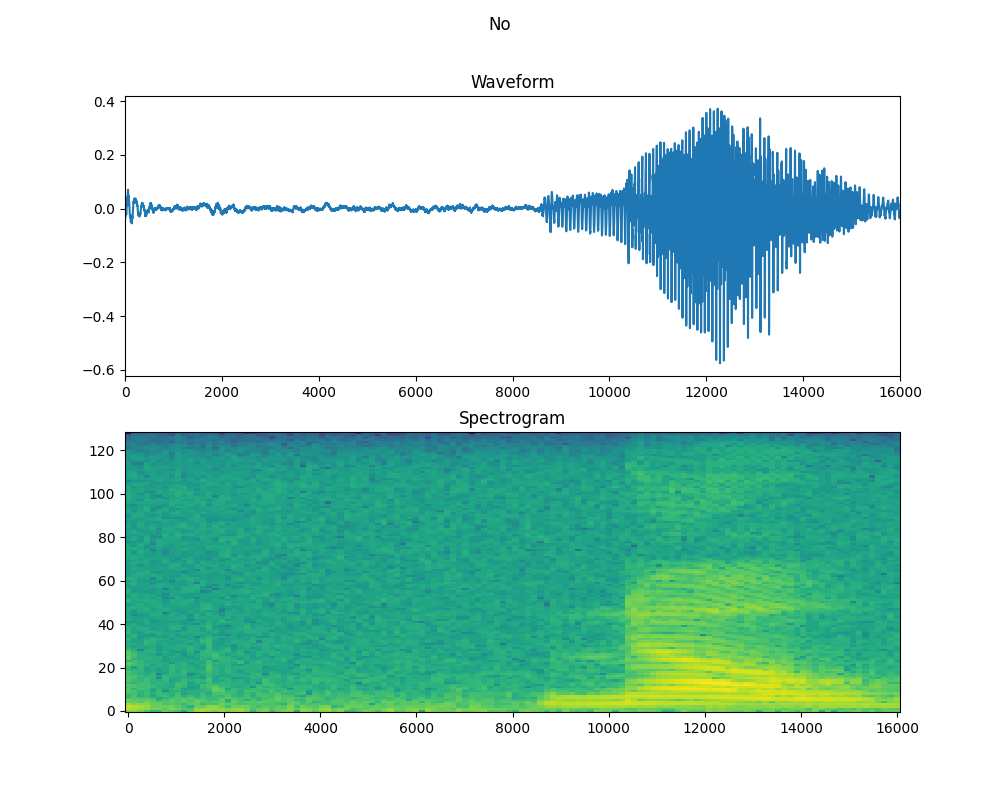

In [18]:
plt.close()
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

plt.suptitle(label.title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

Defining `make_spec_ds` Function

In [19]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls= tf.data.AUTOTUNE)

Implement the `make_spec_ds` function on the data

In [20]:
train_spectrogram_ds = make_spec_ds(X_train)
val_spectrogram_ds = make_spec_ds(val)
test_spectrogram_ds = make_spec_ds(X_test)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

Plotting Spectrograms

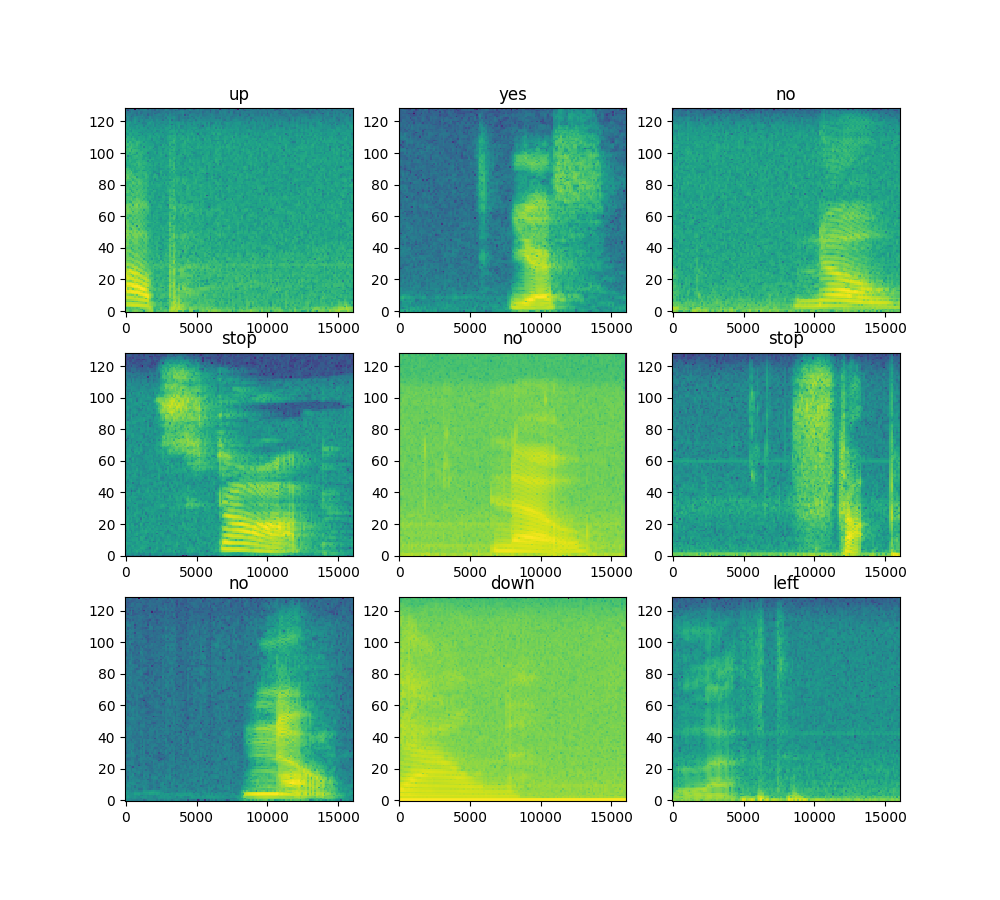

In [22]:
plt.close()

rows, cols = 3, 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 9))


for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Reducing processing time with ‍‍`cache()` command

In [29]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
example_spectrograms.shape[1:]

TensorShape([124, 129, 1])

Modelling

In [41]:
input_shape = example_spectrograms.shape[1:]
print('input shape: %s' % input_shape)

norm_layer = Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = Sequential([
    Input(shape=input_shape),
    Resizing(32, 32),
    norm_layer,
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names))
])

model.summary()

input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)       

Compiling model

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Fitting the model

In [43]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
100/100 [==============================] - 6s 49ms/step - loss: 1.7685 - accuracy: 0.3559 - val_loss: 1.3906 - val_accuracy: 0.5521
Epoch 2/10
100/100 [==============================] - 5s 45ms/step - loss: 1.2421 - accuracy: 0.5577 - val_loss: 0.9756 - val_accuracy: 0.6667
Epoch 3/10
100/100 [==============================] - 4s 43ms/step - loss: 0.9339 - accuracy: 0.6698 - val_loss: 0.8093 - val_accuracy: 0.7135
Epoch 4/10
100/100 [==============================] - 4s 40ms/step - loss: 0.7636 - accuracy: 0.7203 - val_loss: 0.7222 - val_accuracy: 0.7500
Epoch 5/10
100/100 [==============================] - 4s 40ms/step - loss: 0.6544 - accuracy: 0.7691 - val_loss: 0.6145 - val_accuracy: 0.7943
Epoch 6/10
100/100 [==============================] - 4s 40ms/step - loss: 0.5757 - accuracy: 0.7977 - val_loss: 0.5556 - val_accuracy: 0.8099
Epoch 7/10
100/100 [==============================] - 4s 40ms/step - loss: 0.5094 - accuracy: 0.8213 - val_loss: 0.5595 - val_accuracy: 0.8021

Visualizing **Loss** and **Accuracy** plots

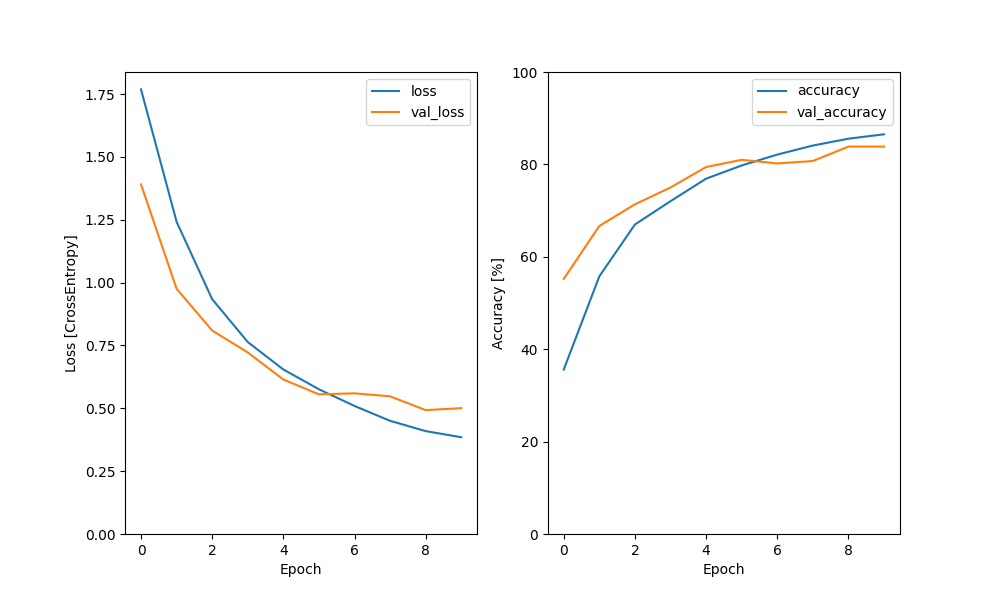

In [61]:
metrics = history.history

plt.close()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel("Loss [CrossEntropy]")

plt.subplot(1,2,2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]');

Evaluating the model

In [62]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 21ms/step - loss: 0.5192 - accuracy: 0.8269


{'loss': 0.5191786289215088, 'accuracy': 0.8269230723381042}